In [66]:
import geopandas
import font_management
import numpy as np
import pandas as pd
from shapely.geometry import Point
import json
import party_information
import matplotlib.patches as mpatches
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

## Prepare the dataset_election_bfs file for the analysis
First we need to process the big file because there's a lot of not needed data and also matches which have to be brought together from the metadata

In [67]:
ELECTION_RESULTS_FILE = 'election_data/dataset_elections_bfs.json'

In [68]:
with open(ELECTION_RESULTS_FILE) as f:
    election_results = json.load(f)
    print(election_results.keys())

dict_keys(['timestamp', 'wahl_jahr', 'spatial_reference', 'stand', 'stand_kantone', 'level_ch', 'level_kantone', 'level_gemeinden'])


Extract important data from the election results

In [69]:
cantonal_results = dict()
for result in election_results['level_kantone']:
    if result['kanton_nummer'] not in cantonal_results.keys():
        cantonal_results[result['kanton_nummer']] = {
            'name': result['kanton_bezeichnung'],
            'parties': {}
        }
    cantonal_results[result['kanton_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_information.party_metadata[result['partei_id']]['name'],
            'group': party_information.party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }

In [70]:
municipal_results = dict()
for result in election_results['level_gemeinden']:
    if result['gemeinde_nummer'] not in municipal_results.keys():
        municipal_results[result['gemeinde_nummer']] = {
            'name': result['gemeinde_bezeichnung'],
            'parties': {}
        }
    municipal_results[result['gemeinde_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_information.party_metadata[result['partei_id']]['name'],
            'group': party_information.party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }
municipal_results

{1: {'name': 'Aeugst am Albis',
  'parties': {1: {'name': 'FDP.Die Liberalen',
    'group': 'conservative',
    'vote_share': 12.733669035,
    'vote_share_delta': -3.68737584,
    'strongest_party': False},
   3: {'name': 'Sozialdemokratische Partei der Schweiz',
    'group': 'left',
    'vote_share': 13.582120439,
    'vote_share_delta': 2.0170183829,
    'strongest_party': False},
   4: {'name': 'Schweizerische Volkspartei',
    'group': 'conservative',
    'vote_share': 34.241567221,
    'vote_share_delta': 3.8606078221,
    'strongest_party': True},
   7: {'name': 'Evangelische Volkspartei der Schweiz',
    'group': 'middle',
    'vote_share': 3.845623232,
    'vote_share_delta': 0.6181528912,
    'strongest_party': False},
   9: {'name': 'Partei der Arbeit / Solidarität',
    'group': 'left',
    'vote_share': 0.193143409,
    'vote_share_delta': 0.0310330265,
    'strongest_party': False},
   12: {'name': 'Grün-Alternative (inkl. POCH)',
    'group': 'left',
    'vote_share': 0.

Make evaluation on party strength on municipal level

In [71]:
def calc_winning_group(party_dict: dict, attribute_to_sum: str) -> str:
    """Takes the parties dictionary iterates through it and sums the attribute together which are defined in the attribute to sum. It's a necessity that the attribute_to_sum is existing in the dictionary, otherwise it will fail. Returns the winning group."""
    conservative_sum = 0
    middle_sum = 0
    left_sum = 0
    for key, value in party_dict.items():
        if value[attribute_to_sum] is None:
            pass
        else:
            if key in party_information.conservative_id:
                conservative_sum += value[attribute_to_sum]
            elif key in party_information.middle_id:
                middle_sum += value[attribute_to_sum]
            elif key in party_information.left_id:
                left_sum += value[attribute_to_sum]
    if conservative_sum > middle_sum and conservative_sum > left_sum:
        return 'conservative'
    elif middle_sum > conservative_sum and middle_sum > left_sum:
        return 'middle'
    elif left_sum > middle_sum and left_sum > conservative_sum:
        return 'left'

In [72]:
winner_aggregation = {'conservative': [], 'middle': [], 'left': []}
grower_aggregation = {'conservative': [], 'middle': [], 'left': []}
for _id, municipal_data in municipal_results.items():
    municipal_data['vote_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share')
    municipal_data['growth_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share_delta')
    if municipal_data['vote_winner'] == 'conservative':
        winner_aggregation['conservative'].append(_id)
    elif municipal_data['vote_winner'] == 'middle':
        winner_aggregation['middle'].append(_id)
    elif municipal_data['vote_winner'] == 'left':
        winner_aggregation['left'].append(_id)
    
    if municipal_data['growth_winner'] == 'conservative':
        grower_aggregation['conservative'].append(_id)
    elif municipal_data['growth_winner'] == 'middle':
        grower_aggregation['middle'].append(_id)
    elif municipal_data['growth_winner'] == 'left':
        grower_aggregation['left'].append(_id)

# Find the municipality with the biggest numbers for a later annotation 

In [73]:
def find_municipality_with_highest_win_and_grow(winner_aggregation, grower_aggregation, attribute_to_check):
    for area in ['conservative', 'middle', 'left']:
        winner_area = max(
            winner_aggregation[area],
            key=lambda x: municipal_results[x]['parties'].get(attribute_to_check, 0)
        )
        grower_area = max(
            grower_aggregation[area],
            key=lambda x: municipal_results[x]['parties'].get(attribute_to_check, 0)
        )

        print(f"For {area} area:")
        print(f"Municipality with the biggest win ({attribute_to_check}): {winner_area} - Value: {municipal_results[winner_area]['parties'].get(attribute_to_check, 0)}")
        print(f"Municipality with the biggest grow ({attribute_to_check}): {grower_area} - Value: {municipal_results[grower_area]['parties'].get(attribute_to_check, 0)}")
        print()

# Call the function to find the municipalities with the biggest win and grow for each area
find_municipality_with_highest_win_and_grow(winner_aggregation, grower_aggregation, 'vote_share')


For conservative area:
Municipality with the biggest win (vote_share): 1 - Value: 0
Municipality with the biggest grow (vote_share): 5 - Value: 0

For middle area:
Municipality with the biggest win (vote_share): 1007 - Value: 0
Municipality with the biggest grow (vote_share): 1 - Value: 0

For left area:
Municipality with the biggest win (vote_share): 230 - Value: 0
Municipality with the biggest grow (vote_share): 7 - Value: 0


# Color schema for the three buckets
We decided to have the SVP green for the conservative block, the orange from the middle for the middle parties and the red from the social party for the left-wing parties. This is a very broad simplification but we're thinking that the viewer can associate those colors directly. Of course there are nuances in the party but it's also mostly how the parties collaborate in parliament.

In [74]:
swiss_map = geopandas.read_file('swisstopo/Hoheitsgebiete.shp')
#Drop the Lichtenstein areas with ICC = LI
swiss_map = swiss_map[swiss_map['ICC'] != 'LI']
'''
swiss_map['COLOR_GROWER'] = '#000000'
swiss_map['COLOR_WINNER'] = '#000000'
grower_conditions = [
    (swiss_map['BFS_NUMMER'].isin(grower_aggregation['conservative']), 'COLOR_GROWER', party_information.CONSERVATIVE_COLOR),
    (swiss_map['BFS_NUMMER'].isin(grower_aggregation['middle']), 'COLOR_GROWER', party_information.MIDDLE_COLOR),
    (swiss_map['BFS_NUMMER'].isin(grower_aggregation['left']), 'COLOR_GROWER', party_information.LEFT_COLOR)
]

winner_conditions = [
    (swiss_map['BFS_NUMMER'].isin(winner_aggregation['conservative']), 'COLOR_WINNER', party_information.CONSERVATIVE_COLOR),
    (swiss_map['BFS_NUMMER'].isin(winner_aggregation['middle']), 'COLOR_WINNER', party_information.MIDDLE_COLOR),
    (swiss_map['BFS_NUMMER'].isin(winner_aggregation['left']), 'COLOR_WINNER', party_information.LEFT_COLOR)
]

for condition in grower_conditions:
    swiss_map.loc[condition[0], condition[1]] = condition[2]

for condition in winner_conditions:
    swiss_map.loc[condition[0], condition[1]] = condition[2]
'''
#Adapt the dataframe that we have a column with winner and grower, the column should be filled with 'conservative', 'middle' or 'left'
swiss_map['winning_group'] = ''
swiss_map['growing_group'] = ''
for index, row in swiss_map.iterrows():
    if row['BFS_NUMMER'] in grower_aggregation['conservative']:
        swiss_map.at[index, 'growing_group'] = 'conservative'
    elif row['BFS_NUMMER'] in grower_aggregation['middle']:
        swiss_map.at[index, 'growing_group'] = 'middle'
    elif row['BFS_NUMMER'] in grower_aggregation['left']:
        swiss_map.at[index, 'growing_group'] = 'left'
    else:
        swiss_map.at[index, 'growing_group'] = 'no_data'
    
    if row['BFS_NUMMER'] in winner_aggregation['conservative']:
        swiss_map.at[index, 'winning_group'] = 'conservative'
    elif row['BFS_NUMMER'] in winner_aggregation['middle']:
        swiss_map.at[index, 'winning_group'] = 'middle'
    elif row['BFS_NUMMER'] in winner_aggregation['left']:
        swiss_map.at[index, 'winning_group'] = 'left'
    else:
        swiss_map.at[index, 'winning_group'] = 'no_data'
swiss_map

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,ICC,EINWOHNERZ,HIST_NR,BFS_NUMMER,GEM_TEIL,GEM_FLAECH,SHN,geometry,winning_group,growing_group
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,CH,4650.0,16065.0,3762,0,43861.0,CH18433762,"POLYGON Z ((2812956.113 1194956.023 2980.122, ...",conservative,conservative
1,{B55F9EAE-EB69-4468-A41C-7BB28A6699EE},2022-11-09,2008-11-24,2006,1,2023,1,Verbessert,AV,2023,...,CH,9490.0,15478.0,1631,0,43003.0,CH08001631,"POLYGON Z ((2715953.052 1184819.358 3402.836, ...",conservative,conservative
2,{AB2BA4A5-EB8C-40C7-A259-271DAC93C767},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,CH,1513.0,16066.0,3746,0,34404.0,CH18433746,"POLYGON Z ((2803369.136 1191207.211 3111.081, ...",conservative,conservative
3,{550D0610-1EE3-4748-8F29-88072753FFDC},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,CH,2391.0,16068.0,3543,0,32377.0,CH18413543,"POLYGON Z ((2757776.421 1165789.462 2730.100, ...",middle,conservative
4,{5B0C1705-1D2B-4E53-9970-6BC3DE33A0F7},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,CH,10609.0,16601.0,6037,0,30191.0,CH23036037,"POLYGON Z ((2588810.990 1085590.669 3576.258, ...",middle,conservative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,{7FAC8A17-64F7-4920-B7EC-29A4B4F3630E},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,CH,NaN,12508.0,4257,3,NaN,CH19094257,"POLYGON Z ((2627214.259 1260872.131 482.512, 2...",conservative,conservative
2274,{454AF364-1D3A-4EC8-9033-B5FF8320DBB0},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,CH,NaN,14100.0,3104,2,NaN,CH16003104,"POLYGON Z ((2745229.705 1250219.359 783.966, 2...",middle,middle
2275,{CF0F9771-1C72-4F3D-9476-8D928A01C031},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,CH,NaN,14102.0,3111,3,NaN,CH16003111,"POLYGON Z ((2763958.831 1257025.919 643.663, 2...",middle,middle
2276,{3063AE38-1248-4F21-BADA-F166674E4967},2022-11-10,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,CH,NaN,15155.0,582,2,NaN,CH02500582,"POLYGON Z ((2640788.950 1174038.050 563.770, 2...",conservative,middle


In [75]:
map_canton = geopandas.read_file('swisstopo/Kantonsgebiet.shp')

In [76]:
#Prepare color codding for the map
swiss_map['winning_group_color'] = swiss_map['winning_group'].map(party_information.COLOR_DICT)
swiss_map['growing_group_color'] = swiss_map['growing_group'].map(party_information.COLOR_DICT)
#Fix nan values with a grey color
swiss_map['winning_group_color'] = swiss_map['winning_group_color'].fillna(party_information.GREY_COLOR)
swiss_map['growing_group_color'] = swiss_map['growing_group_color'].fillna(party_information.GREY_COLOR)

In [77]:
# Draw annotation items
central_tg = swiss_map[swiss_map['BFS_NUMMER'] == 4881]
central_bern = swiss_map[swiss_map['BFS_NUMMER'] == 351]
municipality_alps = swiss_map[swiss_map['BFS_NUMMER'] == 1212]
annotation_items = {
    'All conservative thurgau': [central_tg, (0.85, 0.9), party_information.CONSERVATIVE_COLOR],
    'Middle oriented alps': [municipality_alps, (0.525, 0.05), party_information.MIDDLE_COLOR],
    'Leftist cities': [central_bern, (0.1, 0.8), party_information.LEFT_COLOR]
}
arrowprops = {
    'arrowstyle': 'Simple',
    'edgecolor': 'white',
    'facecolor': 'black',
    'linewidth': 1.5,
}
def do_annotations(axis):
    for key, item in annotation_items.items():
        axis.annotate(
            key,
            xy=(item[0]['geometry'].centroid.x, item[0]['geometry'].centroid.y), xycoords='data',
            xytext=item[1], textcoords='axes fraction',
            size=18, va="center", ha="center",
            arrowprops={'connectionstyle': "arc3,rad=-0.2", **arrowprops},
            fontproperties={'family': 'PT Sans', 'weight': 'regular'},
            color=item[2]
        )

/Users/aceto/anaconda3/envs/DVIZ/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/aceto/anaconda3/envs/DVIZ/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


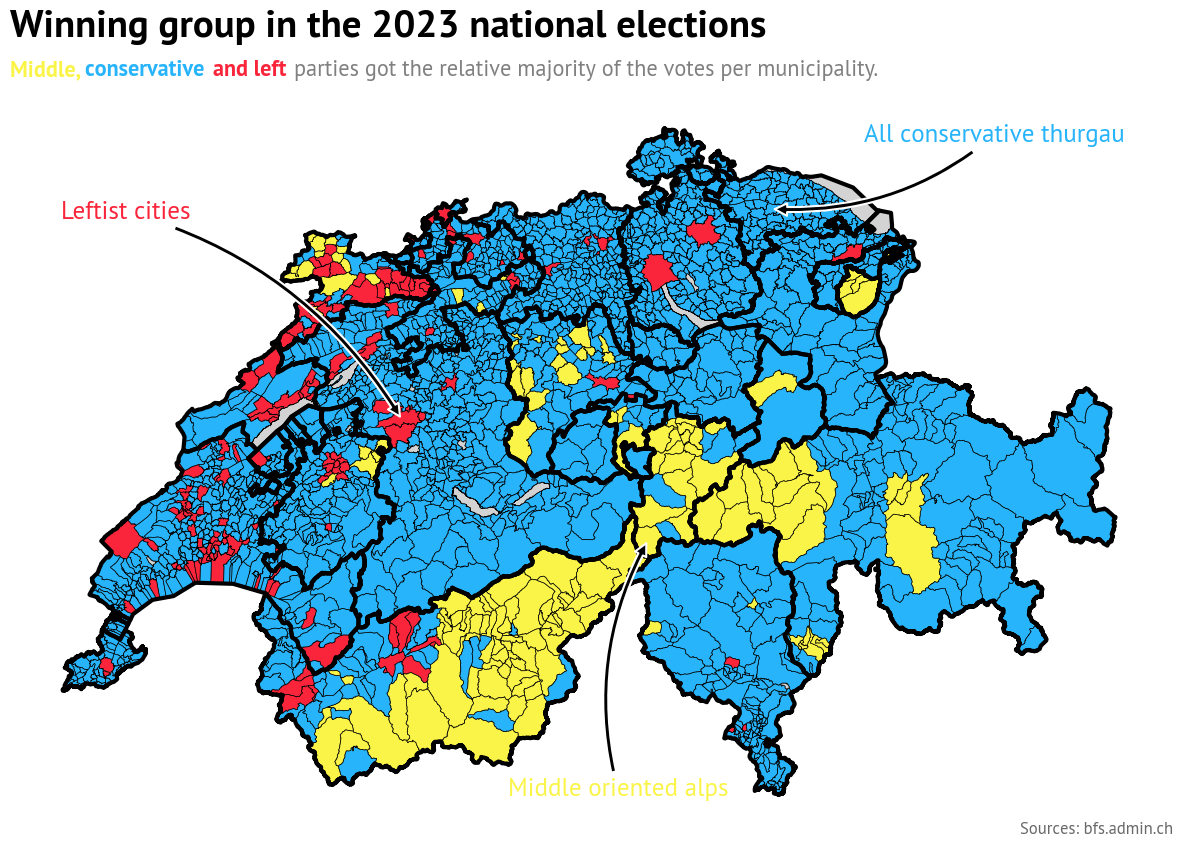

In [78]:
f, ax = plt.subplots(figsize=(15,10))
ax.set_title('Winning group in the 2023 national elections', fontdict=font_management.TITLE_FONT, loc='left', transform=ax.transAxes)
ax.text(s='Middle, ', x=0.00, y=0.97, color=party_information.MIDDLE_COLOR,
         fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='conservative ', x=0.065, y=0.97, color=party_information.CONSERVATIVE_COLOR,
         fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='and left', x=0.175, y=0.97, color=party_information.LEFT_COLOR,
         fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='parties got the relative majority of the votes per municipality.', x=0.245, y=0.97, color='grey', 
fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
results = swiss_map.plot(ax=ax, color=swiss_map['winning_group_color'], linewidth=0.5, edgecolor='black')
map_canton.plot(ax=ax, linewidth=3, edgecolor='black', color=(0, 0, 0, 0)) # Thicker canton borders
# Calculate the y-axis limits with a buffer for the text
ylim = ax.get_ylim()
y_buffer = (ylim[1] - ylim[0]) * 0.05  # 10% buffer
ax.set_ylim(ylim[0], ylim[1] + y_buffer)
do_annotations(ax)
f.text(x=0.8, y=0.1, s="Sources: bfs.admin.ch", fontdict=font_management.ANNOTATION_FONT)
ax.set_axis_off()

Text(0.8, 0.1, 'Sources: bfs.admin.ch')

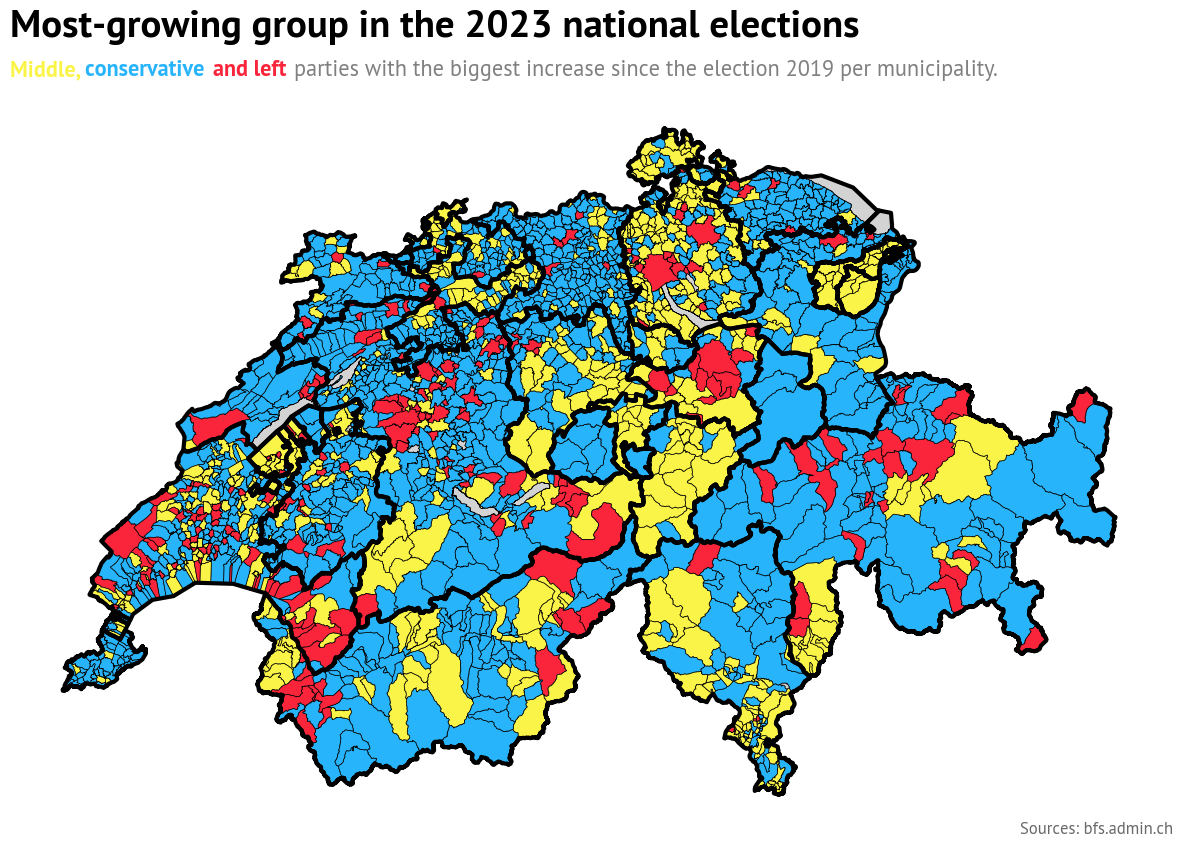

In [79]:
f, ax = plt.subplots(figsize=(15,10))
ax.set_title('Most-growing group in the 2023 national elections', fontdict=font_management.TITLE_FONT, loc='left', transform=ax.transAxes)
ax.text(s='Middle, ', x=0.00, y=0.97, color=party_information.MIDDLE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='conservative ', x=0.065, y=0.97, color=party_information.CONSERVATIVE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='and left', x=0.175, y=0.97, color=party_information.LEFT_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='parties with the biggest increase since the election 2019 per municipality.', x=0.245, y=0.97, color='grey',
        fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
results = swiss_map.plot(ax=ax, color=swiss_map['growing_group_color'], linewidth=0.5, edgecolor='black')
map_canton.plot(ax=ax, linewidth=3, edgecolor='black', color=(0, 0, 0, 0)) # Thicker canton borders
ax.set_axis_off()
ylim = ax.get_ylim()
y_buffer = (ylim[1] - ylim[0]) * 0.05  # 10% buffer
ax.set_ylim(ylim[0], ylim[1] + y_buffer)
f.text(x=0.8, y=0.1, s="Sources: bfs.admin.ch", fontdict=font_management.ANNOTATION_FONT)

In [80]:
# Now we're doing a small multiple implementation which will have three maps next to each other

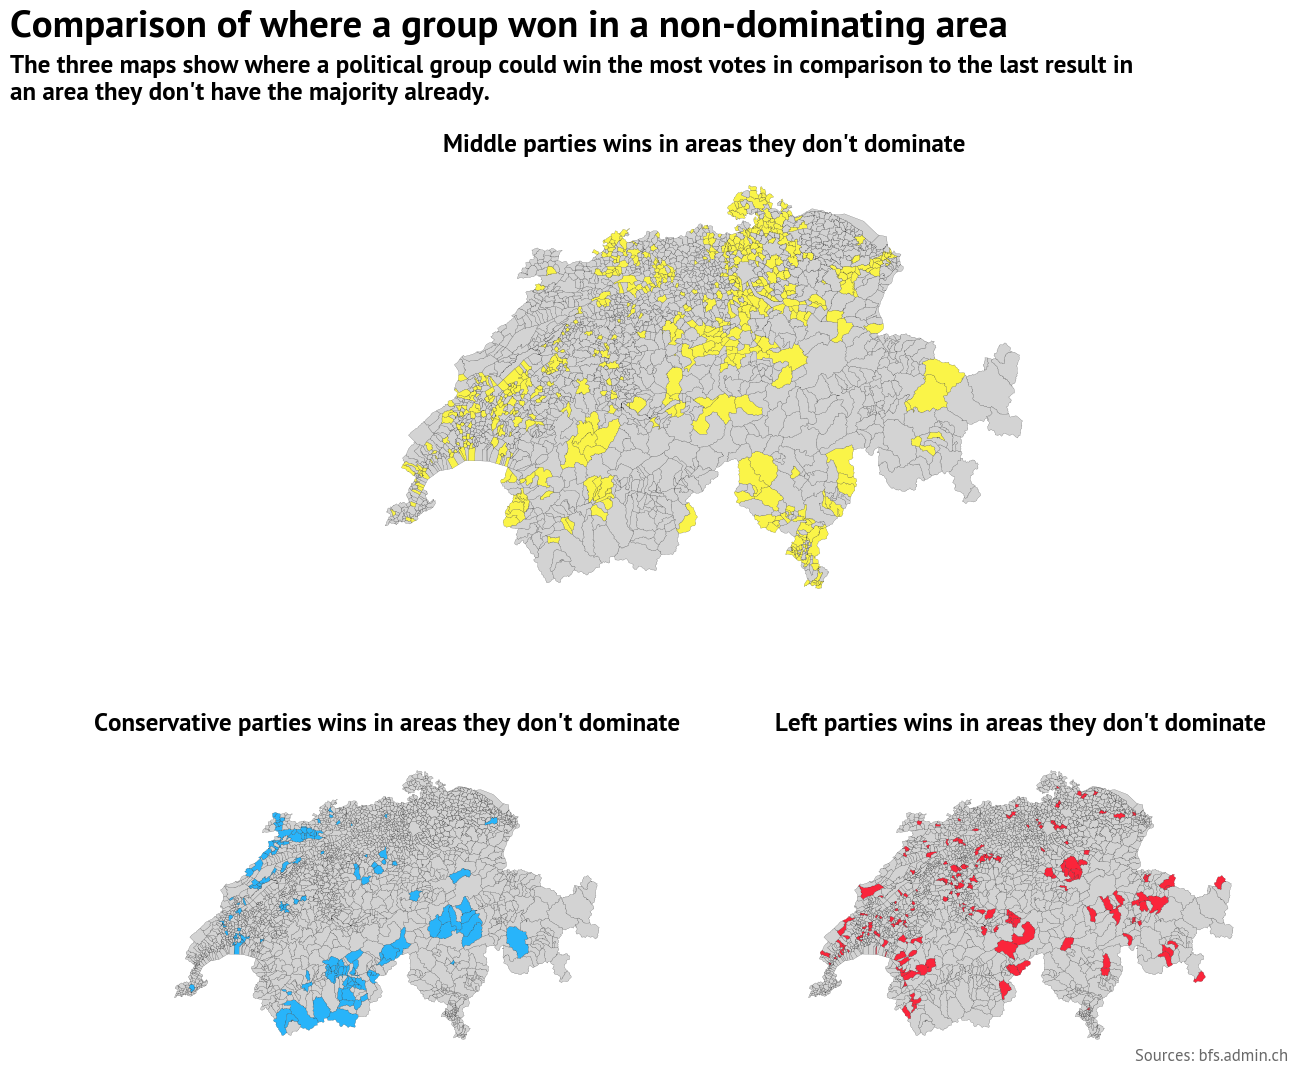

In [99]:
def color_for_scenario(data, winning_group_condition, growing_group, color):
    """
    Return color for each area based on the specified condition.
    """
    return [
        color if row['winning_group'] != winning_group_condition and row['growing_group'] == growing_group
        else party_information.GREY_COLOR
        for _, row in data.iterrows()
    ]
fig, axes = plt.subplot_mosaic(
    "CC;AB",
    height_ratios=[1.5, 1],  # Adjust the first ratio for the title space
    figsize=(15, 12),  # You might want to adjust the figure size as well
    gridspec_kw={'hspace': 0.4, 'top': 0.85}  # Adjust 'top' for space above the top row
)
# Main title of the figure
fig.text(x=0.05, y=0.95,s='Comparison of where a group won in a non-dominating area', fontdict=font_management.TITLE_FONT)
# Subtitle of the figure!
fig.text(x=0.05, y=0.9, s="The three maps show where a political group could win the most votes in comparison to the last result in \nan area they don't have the majority already.", fontdict=font_management.SUBTITLE_FONT)
# First Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'conservative', 'conservative', party_information.CONSERVATIVE_COLOR)
swiss_map.plot(ax=axes['A'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['A'].set_title('Conservative parties wins in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
axes['A'].set_axis_off()

# Second Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'middle', 'middle', party_information.MIDDLE_COLOR)
swiss_map.plot(ax=axes['C'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['C'].set_title('Middle parties wins in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
axes['C'].set_axis_off()

# Third Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'left', 'left', party_information.LEFT_COLOR)
swiss_map.plot(ax=axes['B'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['B'].set_title('Left parties wins in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
axes['B'].set_axis_off()

fig.text(x=0.8, y=0.1, s="Sources: bfs.admin.ch", fontdict=font_management.ANNOTATION_FONT)
plt.show()